In [45]:
import requests
import geopandas as gpd
import pandas as pd
import rasterio as rio
from rasterio.features import shapes
from rasterio.transform import *
from rasterio.plot import show
from rasterio.mask import geometry_mask, mask
from rasterio.warp import reproject
from shapely.geometry import mapping, shape, Polygon, Point, MultiPolygon
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from datetime import timedelta
from lxml import etree
from xml.dom import minidom
from os.path import split, join
from scipy.ndimage import zoom
from skimage import img_as_ubyte
from skimage.exposure import equalize_adapthist as _hist
import seaborn as sns
import pyproj
from functools import partial


import numpy as np
import os

%matplotlib inline
%config InlineBackend.figure_format = 'png'
plt.rcParams['figure.dpi'] = 70
plt.rcParams['figure.figsize'] = (27, 9)
plt.rcParams['font.size'] = 12

# ASO UNet Prep

There are several goals here, in service of the eventual goal of using a u-net neural architecture to learn snow/no-snow maps from ASO snow observations and Planet Labs imagery. 

**General Arc:**
1. Align ASO Rasters to a Planet image
2. Create files: the image, and the snow map. 
3. Tile both the image and snow map into (512,512) in order to feed u-net architecture. 
---
## Load the Data

In [2]:
YEAR = 2017
asodb = "../data/aso-urls.csv"

asourls = pd.read_csv(asodb, parse_dates=[0]).set_index('date')
asourls = asourls[asourls.index.year == YEAR]
display(asourls)
image = asourls.iloc[1]
asoImage = rio.open(image.url)
asoData = asoImage.read(1)
asoData[asoData == -9999] = 0

image_crs = ccrs.epsg(asoImage.crs['init'].split(":")[1])


,url
date,
2017-03-03,https://aso.jpl.nasa.gov/_include/new_geotiff/...
2017-04-01,https://aso.jpl.nasa.gov/_include/new_geotiff/...


In [33]:
print("Chosen ASO: {}".format(image.name))

Chosen ASO: 2017-04-01 00:00:00


In [42]:
SATIMAGENAME = "../images/ASO/0_20170404_180056_0e19.tif"
SATIMAGEROOT, SATIMAGEFILE = split(SATIMAGENAME)

In [4]:
xmin = asoImage.transform[0]
xmax = asoImage.transform[0] + asoImage.transform[1]*asoImage.width
ymin = asoImage.transform[3] + asoImage.transform[5]*asoImage.height
ymax = asoImage.transform[3]

asoExtent  = [xmin, xmax, ymin, ymax]

/home/ubuntu/anaconda3/envs/tensorflow_p36_geo/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)


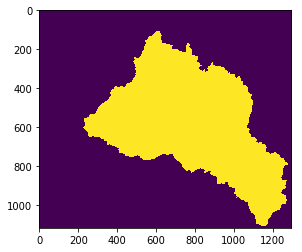

In [5]:
show(asoImage.read(1))

In [39]:
doc = etree.parse(split(SATIMAGENAME)[0].split('.')[0] + ".xml")
root = doc.getroot()
footprint = root.find("gml:target", root.nsmap).find("ps:Footprint", root.nsmap).getchildren()[0].getchildren()[0].getchildren()[0].find("gml:Polygon", root.nsmap).getchildren()[0].getchildren()[0].getchildren()[0].text

satfootprint = Polygon([([float(z) for z in xy.split(',')]) for xy in footprint.split(" ")])

OSError: Error reading file '0_20170404_180056_0e19.xml': failed to load external entity "0_20170404_180056_0e19.xml"

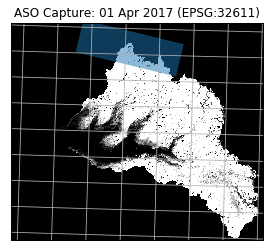

In [7]:
ax = plt.axes(projection=ccrs.epsg("32611"))
ax.imshow(asoImage.read(1).astype('float32'), origin='upper', cmap="binary_r", vmax=1, vmin=0, extent=asoExtent, transform=ccrs.epsg("32611"))
ax.set_title("ASO Capture: {:%d %b %Y} (EPSG:{})".format(image.name, image_crs.epsg_code))
ax.add_geometries([satfootprint], crs=ccrs.PlateCarree(), alpha=0.5)
ax.gridlines()


## Isolate overlap

*Preliminary approach:* 
1. Crop ASO raster to satellite image extent
2. Isolate ASO polygon
3. Crop satellite image to ASO polygon
4. ???

In [8]:
asoImage.crs['init']
asoCrs = ccrs.epsg(asoImage.crs['init'].split(':')[1])
xs, ys = satfootprint.exterior.coords.xy
satfootprint_projected = Polygon(asoCrs.transform_points(ccrs.PlateCarree(), np.array(xs), np.array(ys)))

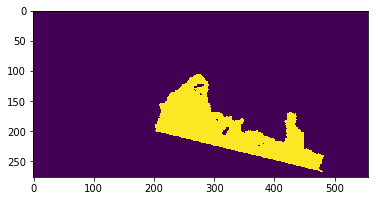

In [9]:
asoMasked, asoMaskTransform = mask(asoImage, [mapping(satfootprint_projected)], crop=True)
asoMask = asoMasked.mask
asoMasked = asoMasked.data.squeeze()
asoMasked[asoMasked > 0.1] = 1
asoMasked[asoMasked <= 0.1] = 0
plt.imshow(asoMasked)

In [10]:
set(asoMasked.flatten())

{0.0, 1.0}

In [11]:
features = list(rio.features.shapes(asoMasked, transform=asoMaskTransform, connectivity=8))
feats, feat_values = zip(*features)

In [12]:
asopolyextract = Polygon(shell = feats[feat_values.index(1)]['coordinates'][0], holes = feats[feat_values.index(1)]['coordinates'][:-1])

In [13]:
maskHeight = asoMasked.shape[0]
maskWidth = asoMasked.shape[1]
asoMaskTransform_gdal = asoMaskTransform.to_gdal()
xmin = asoMaskTransform_gdal[0]
xmax = asoMaskTransform_gdal[0] + asoMaskTransform_gdal[1]*maskWidth
ymin = asoMaskTransform_gdal[3] + asoMaskTransform_gdal[5]*maskHeight
ymax = asoMaskTransform_gdal[3]
asoMaskedExtent = [xmin, xmax, ymin, ymax]

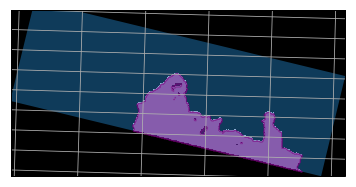

In [15]:
ax = plt.axes(projection=ccrs.epsg("32611"))
ax.imshow(asoMasked.astype('float32'), origin='upper', cmap="binary_r", vmax=1, vmin=0, extent=asoMaskedExtent, transform=ccrs.epsg("32611"))
#ax.set_title("ASO Capture: {:%d %b %Y} (EPSG:{})".format(asoimage.name, image_crs.epsg_code))
ax.add_geometries([satfootprint], crs=ccrs.PlateCarree(), alpha=0.5)
ax.add_geometries([asopolyextract], crs=ccrs.epsg("32611"), color='purple', alpha=0.5)
ax.gridlines()


---


In [19]:
def openImage(imagef, coeffs=True):   
    image = rio.open(imagef)
    if not coeffs: return(image)
    
    path, base = os.path.split(imagef)
    root = base.split(".")[0]
    meta = minidom.parse(open(os.path.join(path, root + ".xml")))
    nodes = meta.getElementsByTagName("ps:bandSpecificMetadata")

    coeffs = {}
    for node in nodes:
        bn = node.getElementsByTagName("ps:bandNumber")[0].firstChild.data
        if bn in ['1', '2', '3', '4']:
            i = int(bn)
            value = node.getElementsByTagName("ps:reflectanceCoefficient")[0].firstChild.data
            coeffs[i] = float(value)
    
    return((image, coeffs))

satimage, coefs = openImage("../images/ASO/0_20170404_180056_0e19.tif")




In [20]:
image.name

Timestamp('2017-04-01 00:00:00')

In [21]:
coefs

{1: 2.18881960131e-05,
 2: 2.31218615715e-05,
 3: 2.58209230633e-05,
 4: 3.90278094666e-05}

In [23]:
satCrs = ccrs.epsg(satimage.crs['init'].split(':')[1])
xs, ys = asopolyextract.exterior.coords.xy
asomask_projected = Polygon(satCrs.transform_points(asoCrs, np.array(xs), np.array(ys)))

In [24]:
satmasked, satmaskTransform = mask(satimage, [mapping(asomask_projected)], crop=True, nodata=0)

In [25]:
maskHeight = satmasked.data[0].shape[0]
maskWidth = satmasked.data[0].shape[1]
satmaskTransform_gdal = satmaskTransform.to_gdal()
xmin = satmaskTransform_gdal[0]
xmax = satmaskTransform_gdal[0] + satmaskTransform_gdal[1]*maskWidth
ymin = satmaskTransform_gdal[3] + satmaskTransform_gdal[5]*maskHeight
ymax = satmaskTransform_gdal[3]
satmaskedextent = [xmin, xmax, ymin, ymax]

In [28]:
satimage_toa = np.stack([_hist(satmasked.data[2] * coefs[3]), 
                        _hist(satmasked.data[1] * coefs[2]), 
                        _hist(satmasked.data[0] * coefs[1])])


satimage_toa = satimage_toa.transpose((1, 2, 0))

/home/ubuntu/anaconda3/envs/tensorflow_p36_geo/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


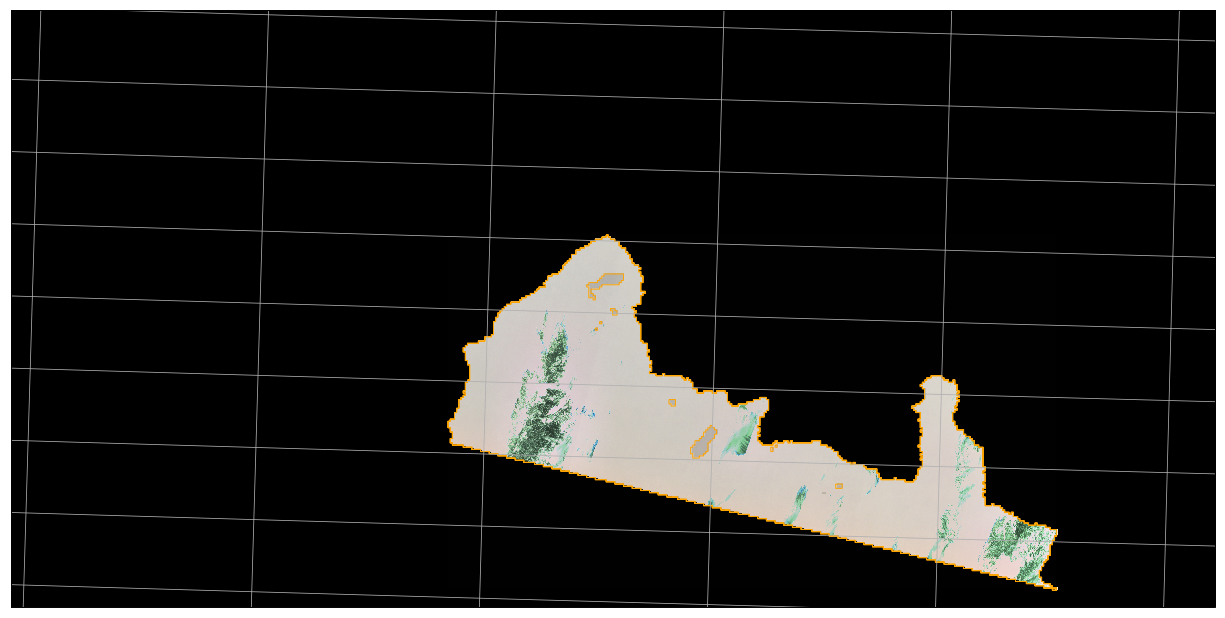

In [30]:
ax = plt.axes(projection=ccrs.epsg("32611"))
ax.imshow(asoMasked.astype('float32'), origin='upper', cmap="binary_r", vmax=1, vmin=0, extent=asoMaskedExtent, transform=ccrs.epsg("32611"))
#ax.set_title("ASO Capture: {:%d %b %Y} (EPSG:{})".format(image.name, image_crs.epsg_code))
ax.imshow(satimage_toa, origin='upper', extent = satmaskedextent, transform=ccrs.epsg("32611"))
#ax.add_geometries([satfootprint], crs=ccrs.PlateCarree(), alpha=0.5)
ax.add_geometries([asopolyextract], crs=ccrs.epsg("32611"), facecolor='none', alpha=1, edgecolor='orange')
ax.imshow(asoMasked.astype('float32'), origin='upper', cmap="binary_r", vmax=1, vmin=0, extent=asoMaskedExtent, transform=ccrs.epsg("32611"), alpha=0.1)

ax.gridlines()
plt.tight_layout()